In [ ]:
# Enhanced & Optimized SUYA Classifier Pipeline - Versi Canggih dan Cepat

# ==============================================================================
# 1. SETUP DAN INSTALLASI
# ==============================================================================

# Instalasi library dengan versi stabil dan kompatibel
!pip install -q \
    scikit-learn==1.3.2 \
    numpy==1.24.4 \
    joblib==1.2.0 \
    Sastrawi \
    gensim \
    shap \
    flask \
    nltk \
    imbalanced-learn \
    transformers \
    datasets \
    nlpaug

import os
os.kill(os.getpid(), 9)  # Restart runtime Colab agar semua install aktif sempurna

In [1]:
import pandas as pd
import numpy as np
import re
import random
from itertools import chain

# Text processing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

from nltk.sentiment import SentimentIntensityAnalyzer

import nltk.data
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix, hstack

# Word Embedding
from gensim.models import Word2Vec

# Augmentasi NLP
import nlpaug.augmenter.word as naw

# ==============================================================================
# 3. PERSIAPAN DATA
# ==============================================================================

raw_data = pd.read_csv("aspirasisuya2324.csv")

stemmer = StemmerFactory().create_stemmer()
sia = SentimentIntensityAnalyzer()

stopwords = set([
    'yang','dan','di','ke','dari','untuk','pada','dengan',
    'saya','kami','adalah','itu','ini','juga','atau','agar',
    'mahasiswa','kelas','lebih','baik','ha','tu'
])

exceptions = {
    'dosen','kelas','kuliah','materi','pembelajaran','administrasi',
    'belajar','zoom','tugas','rekaman','offline','online','sks','ukt','krs'
}

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'(\b\w+)(nya|ku|mu|lah|pun)\b', r'\1', text)
    words = text.split()
    words = [w for w in words if w not in stopwords]
    words = [w if w in exceptions else stemmer.stem(w) for w in words]
    return ' '.join(words)

def is_clean_text(text):
    txt = str(text).lower()
    if len(txt) < 8 or len(txt.split()) < 3:
        return False
    placeholders = ['masukan aspirasimu','isi disini','tulis disini']
    return not any(ph in txt for ph in placeholders)

# Kata kunci prioritas untuk fitur khusus
prioritized_keywords = {
    'fasilitas': [
        'gedung', 'ruang kelas', 'kursi', 'meja', 'papan tulis', 'proyektor',
        'ac', 'kipas', 'atap', 'bocor', 'wc', 'toilet', 'bersih', 'kotor',
        'wifi', 'internet', 'lambat', 'parkir', 'aman', 'laboratorium', 'lab'
    ],
    'dosen': [
        'dosen', 'pengajar', 'cara mengajar', 'penjelasan dosen', 'menjelaskan',
        'tidak hadir', 'telat', 'marah', 'killer', 'galak', 'asik',
        'susah dihubungi', 'pelit nilai', 'tidak adil', 'sikap dosen'
    ],
    'pembelajaran': [
        'belajar', 'pembelajaran', 'materi', 'bahan ajar', 'kurikulum', 'sulit', 'tidak paham',
        'zoom', 'rekaman', 'gmeet', 'offline', 'online', 'hybrid',
        'tugas', 'kuis', 'ujian', 'uts', 'uas', 'praktikum', 'jadwal kuliah', 'bentrok'
    ],
    'ormawa': [
        'ormawa', 'himaprodi', 'himpunan', 'bem', 'ukm', 'lkm',
        'kegiatan', 'event', 'proker', 'program kerja', 'panitia', 'camp'
    ],
    'administrasi': [
        'sks', 'krs', 'ukt', 'biaya', 'bayar', 'pembayaran', 'tagihan',
        'admin', 'administrasi', 'birokrasi', 'lambat', 'sulit', 'cuti',
        'registrasi', 'siakad', 'layanan akademik', 'keuangan'
    ]
}

flat_keywords = list(set([w.lower() for w in chain.from_iterable(prioritized_keywords.values())]))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Cleaning
raw_data = raw_data.dropna(subset=['aspirasi', 'kategori'])
raw_data['kategori'] = raw_data['kategori'].replace({
    'pembelajaran offline': 'pembelajaran',
    'pembelajaran online': 'pembelajaran'
})
raw_data['cleaned'] = raw_data['aspirasi'].apply(clean_text)
raw_data = raw_data[raw_data['cleaned'].apply(is_clean_text)]

# Augmentasi
aug = naw.SynonymAug(aug_src='wordnet')
augmented = []
for label in ['administrasi','pembelajaran']:
    subset = raw_data[raw_data['kategori']==label]
    for _, row in subset.iterrows():
        for _ in range(5):
            new_text = aug.augment(row['aspirasi'])
            cleaned = clean_text(new_text)
            if is_clean_text(cleaned):
                augmented.append({'aspirasi': new_text, 'kategori': label, 'cleaned': cleaned})
raw_data = pd.concat([raw_data, pd.DataFrame(augmented)], ignore_index=True)

# Penyeimbangan
from sklearn.utils import resample
labels = ['fasilitas','dosen','ormawa','pembelajaran','administrasi']
target_per_class = 150
balanced_data = []
for label in labels:
    subset = raw_data[raw_data['kategori'] == label]
    if len(subset) < target_per_class:
        extra = resample(subset, replace=True, n_samples=target_per_class - len(subset), random_state=42)
        subset = pd.concat([subset, extra])
    else:
        subset = subset.sample(n=target_per_class, random_state=42)
    balanced_data.append(subset)
data = pd.concat(balanced_data).reset_index(drop=True)

/tmp/ipython-input-2-598625084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['kategori'] = raw_data['kategori'].replace({


In [3]:
from sklearn.model_selection import GridSearchCV

class AdditionalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, keywords=None):
        self.keywords = keywords
        self._keywords = None
        self.sia = SentimentIntensityAnalyzer()

    def fit(self, X, y=None):
        if isinstance(self.keywords, dict):
            self._keywords = list(set(chain.from_iterable(self.keywords.values())))
        else:
            self._keywords = list(set(self.keywords))
        return self

    def transform(self, X):
        lens = csr_matrix(X.apply(lambda x: len(x.split())).values.reshape(-1, 1))
        kw = csr_matrix(X.apply(lambda x: sum(w in x.split() for w in self._keywords)).values.reshape(-1, 1))
        senti = csr_matrix(X.apply(lambda x: self.sia.polarity_scores(x)['compound']).values.reshape(-1, 1))
        return hstack([lens, kw, senti])

# Label Encoding
le = LabelEncoder()
y = le.fit_transform(data['kategori'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned'], y, test_size=0.2, stratify=y, random_state=42
)

# Feature Engineering
feature_union = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,3), min_df=2, sublinear_tf=True)),
    ('keywords', CountVectorizer(vocabulary=flat_keywords)),
    ('additional', AdditionalFeatures(prioritized_keywords))  # ✅ Perbaikan DI SINI
])

# Pipeline dengan Random Forest (versi stabil)
pipeline = Pipeline([
    ('features', feature_union),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ))
])

# 🔍 Hyperparameter tuning dengan GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=1
)

print("🚀 Training with GridSearchCV...")
grid_search.fit(X_train, y_train)

print(f"✅ Best Params: {grid_search.best_params_}")
print(f"✅ Best CV Score: {grid_search.best_score_:.4f}")

# Gunakan model terbaik
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

🚀 Training with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=300; total time=   0.8s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, clas

📊 Classification Report (RandomForest Only):

              precision    recall  f1-score   support

administrasi       0.88      0.97      0.92        30
       dosen       0.87      0.87      0.87        30
   fasilitas       0.82      0.93      0.87        30
      ormawa       0.97      0.93      0.95        30
pembelajaran       0.96      0.77      0.85        30

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



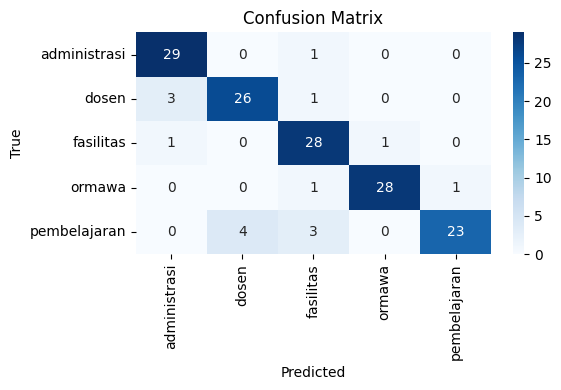


📊 Manual Metrics:
Akurasi     : 0.8933333333333333
Precision   : 0.898566906386379
Recall      : 0.8933333333333333
F1-Score    : 0.8926611963052642

✅ Mean CV F1 Score (RandomForest Only): 0.8682583390057996


In [5]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===============================
# EVALUASI KLASIFIKASI: RandomForest
# ===============================

print("📊 Classification Report (RandomForest Only):\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Manual metrik klasifikasi
print("\n📊 Manual Metrics:")
print("Akurasi     :", accuracy_score(y_test, y_pred))
print("Precision   :", precision_score(y_test, y_pred, average='macro'))
print("Recall      :", recall_score(y_test, y_pred, average='macro'))
print("F1-Score    :", f1_score(y_test, y_pred, average='macro'))

# Cross-validation score
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, data['cleaned'], y, cv=5, scoring='f1_macro')
print("\n✅ Mean CV F1 Score (RandomForest Only):", np.mean(cv_scores))
